In [1]:
from dataclasses import replace
from dnadb import dna, fasta, sample
from lmdbm import Lmdb
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import sys
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Optional
import wandb

In [2]:
sys.path.append("../src")
from deepdna.nn.data_generators import SampleGenerator, _encode_sequences
from deepdna.nn.models import load_model, setbert

In [3]:
tfu.devices.select_gpu(0)

2023-05-29 11:54:23.394363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 11:54:23.394702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 11:54:23.401430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 11:54:23.401671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 11:54:23.401853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
output_path = Path("/home/dwl2x/work/Datasets/Walker_Alex")
output_path.mkdir(exist_ok=True)

In [5]:
fasta_path = Path("/home/shared/walker_lab/alex/P_A_221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.pick.opti_mcc.0.03.pick.0.03.abund.0.03.pick.fasta")
otu_list_path = Path("/home/shared/walker_lab/digitalocean/Alex_SFD/shared_list/221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.asv.list")
otu_shared_path = Path("/home/shared/walker_lab/digitalocean/Alex_SFD/shared_list/221205_cmfp.trim.contigs.pcr.good.unique.good.filter.unique.precluster.denovo.vsearch.asv.shared")
metadata_path = Path("/home/shared/walker_lab/alex/230320_sfdspatial_meta_clean.csv")

## FASTA DB

In [6]:
def clean_entry(entry: fasta.FastaEntry):
    sequence = re.sub(r"[^" + dna.ALL_BASES + r"]", "", entry.sequence)
    return replace(entry, sequence=sequence)

In [7]:
# factory = fasta.FastaDbFactory(output_path / "alex.fasta.db")
# for entry in tqdm(map(clean_entry, fasta.entries(fasta_path))):
#     if len(entry) < 250:
#         continue
#     factory.write_entry(entry)
# factory.close()

In [8]:
fasta_db = fasta.FastaDb(output_path / "alex.fasta.db")

---

## Sample OTU Index

In [9]:
# with open(otu_list_path) as f:
#     keys = f.readline().strip().split('\t')
#     values = f.readline().strip().split('\t')
# otu_index = dict(zip(keys[2:], values[2:]))

In [10]:
# list(otu_index.values())[:5]

In [11]:
# factory = fasta.FastaIndexDbFactory(output_path / "alex.fasta.index.db")
# for i, asv in enumerate(tqdm(otu_index)):
#     fasta_id = otu_index[asv]
#     if fasta_id not in fasta_db:
#         continue
#     factory.write_entry(fasta_db[fasta_id], key=asv)
# factory.close()

In [12]:
index_db = fasta.FastaIndexDb(output_path / "alex.fasta.index.db")

---

## Load Metadata

In [13]:
# metadata = pd.read_csv(metadata_path, index_col=0)
# metadata

In [14]:
# metadata_sample_names = set(metadata.index.to_list())

---

## Sample Mapping

In [15]:
# with open(otu_shared_path) as f:
#     header = f.readline().strip().split('\t')
#     lines = [line.strip().split('\t') for line in tqdm(f)]
# len(lines)

In [16]:
# cols = [i for i in range(3, len(header)) if index_db.contains_key(header[i])]

In [17]:
# header[:5]

In [18]:
# index_db.key_to_fasta_id("ASV0000004")

In [19]:
# indices = [i for i in tqdm(range(3, len(header))) if index_db.contains_key(header[i])]

In [20]:
# fasta_ids = {i: index_db.key_to_fasta_id(header[i]) for i in tqdm(indices)}

In [21]:
# factory = sample.SampleMappingDbFactory(output_path / "alex.fasta.mapping.db")
# for row in tqdm(lines):
#     sample_name = row[1]
#     if sample_name not in metadata_sample_names:
#         continue
#     sample_factory = sample.SampleMappingEntryFactory(sample_name, index_db)
#     for i in indices:
#         if (count := int(row[i])) == 0:
#             continue
#         fasta_id = fasta_ids[i]
#         sample_factory.add_entry(fasta_db[fasta_id], count)
#     factory.write_entry(sample_factory.build())
# factory.close()

In [22]:
mapping = sample.SampleMappingDb(output_path / "alex.fasta.mapping.db", index_db)

In [23]:
sample_names = set([sample.name for sample in mapping])
len(sample_names)

737

---

## Pathogen Load TSVs

In [24]:
# with open(output_path / "alex.pathogen_load.tsv", "w") as f:
#     f.write(f"label\tpathogen_load\n")
#     for index, row in metadata.iterrows():
#         if index not in sample_names:
#             continue
#         f.write(f"{index}\t{row['log_copy_number']}\n")

---

## Data Generator

In [25]:
# p = pd.read_csv(output_path / "alex.pathogen_load.tsv", sep="\t", index_col=0)
# p

In [26]:
from typing import Generic, TypeVar

_T = TypeVar("_T")

class SampleTargetGenerator(SampleGenerator, Generic[_T]):
    def __init__(
        self,
        samples: Iterable[sample.SampleInterface],
        targets: dict[str, _T],
        sequence_length: int,
        kmer: int = 1,
        subsample_size: int|None = None,
        augment_slide: bool = True,
        augment_ambiguous_bases: bool = True,
        batch_size: int = 32,
        batches_per_epoch: int = 100,
        class_weights: Optional[npt.ArrayLike] = None,
        shuffle: bool = True,
        balance: bool = False,
        rng: np.random.Generator = np.random.default_rng()
    ):
        super().__init__(
            samples=samples,
            sequence_length=sequence_length,
            kmer=kmer,
            subsample_size=subsample_size,
            augment_slide=augment_slide,
            augment_ambiguous_bases=augment_ambiguous_bases,
            batch_size=batch_size,
            batches_per_epoch=batches_per_epoch,
            class_weights=class_weights,
            shuffle=shuffle,
            balance=balance,
            rng=rng
        )
        self.targets = targets

    def generate_batch(self, rng: np.random.Generator):
        subsample_size = self.subsample_size or 1
        sequences = np.empty((self.batch_size, subsample_size), dtype=f"<U{self.sequence_length}")
        targets = []
        samples = self.sample_sampler.sample(self.batch_size, self.balance, rng)
        for i, sample in enumerate(samples):
            sequences[i] = tuple(self.sequence_sampler.sample(sample, subsample_size, rng))
            targets.append(self.targets[sample.name])
        sequences = _encode_sequences(sequences, self.augment_ambiguous_bases, self.rng)
        if self.subsample_size is None:
            sequences = np.squeeze(sequences, axis=1) # type: ignore
        if self.kmer > 1:
            sequences = dna.encode_kmers(sequences, self.kmer, not self.augment_ambiguous_bases)
        return sequences.astype(np.int32), np.array(targets, dtype=np.float32)

## Construct Training/Validation Sets

In [27]:
rng = np.random.default_rng(0)

In [28]:
samples = [sample.DemultiplexedFastaSample(fasta_db, entry) for entry in mapping]

In [29]:
targets = pd.read_csv(output_path / "alex.pathogen_load.tsv", sep="\t", index_col=0)["pathogen_load"].astype(np.float32).to_dict()

In [30]:
rng.shuffle(samples)
split_index = int(0.2*len(samples))
train_samples = samples[split_index:]
val_samples = samples[:split_index]

train_targets = {sample.name: targets[sample.name] for sample in train_samples}
val_targets = {sample.name: targets[sample.name] for sample in val_samples}
len(train_targets), len(val_targets)

(590, 147)

In [31]:
def compute_class_weights(samples, targets):
    negative_indices = np.array([1.0 if targets[sample.name] == 0.0 else 0.0 for sample in samples])
    positive_indices = 1 - negative_indices
    negative_weights = negative_indices / np.sum(negative_indices)
    positive_weights = positive_indices / np.sum(positive_indices)
    class_weights = positive_weights/2 + negative_weights/2
    return class_weights

In [32]:
# Test (should be ~= 500)
sum([train_targets[s.name] > 0.0 for s in rng.choice(train_samples, 1000, p=compute_class_weights(train_samples, train_targets))])

/tmp/ipykernel_1229341/3560127358.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sum([train_targets[s.name] > 0.0 for s in rng.choice(train_samples, 1000, p=compute_class_weights(train_samples, train_targets))])


519

In [33]:
train_targets = {k: int(v > 0) for k, v in train_targets.items()}
val_targets = {k: int(v > 0) for k, v in val_targets.items()}


In [34]:
common_args = dict(
    sequence_length = 250,
    kmer = 3,
    subsample_size = 1000,
    batch_size=16
)

train_dataset = SampleTargetGenerator(
    train_samples,
    train_targets,
    class_weights=compute_class_weights(train_samples, train_targets),
    batches_per_epoch=20,
    **common_args
)

val_dataset = SampleTargetGenerator(
    val_samples,
    val_targets,
    class_weights=compute_class_weights(val_samples, val_targets),
    batches_per_epoch=16,
    **common_args
)

## Model Training

In [92]:
# api = wandb.Api()
run = wandb.init(project="setbert-pathogen-load", name="mse")

In [52]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
path = run.use_artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:latest").download()
setbert_encoder = setbert.SetBertEncoderModel(
    load_model(path, setbert.SetBertPretrainModel).base
)
setbert_encoder.base.dnabert_encoder.chunk_size = 256

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


Number of outputs: 8


In [37]:
# setbert_encoder(train_dataset[0][0])

In [53]:
def log_norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    epsilon = 1e-8 # can't compute log of 0
    l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    # l_mu = tf.expand_dims(l_mu,-1)
    # l_sigma = tf.expand_dims(l_sigma,-1)

    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(y_true + epsilon)
    t3 = tf.math.log(2.0)/2.0
    t4 = tf.math.log(np.pi)/2.0
    t5 = tf.math.pow(l_mu-tf.math.log(y_true),2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4+t5
    return loss_

In [54]:
def norm_dist_loss(y_true, y_pred):
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    l_sigma = 1.0
    # l_mu, l_sigma = tf.unstack(y_pred, axis=-1)
    l_mu = y_pred
    # l_mu = tf.expand_dims(l_mu,-1)
    # l_sigma = tf.expand_dims(l_sigma,-1)

    t1 = tf.math.log(l_sigma)
    t2 = tf.math.log(2.0)/2.0
    t3 = tf.math.log(np.pi)/2.0
    t4 = tf.math.pow(l_mu-y_true,2.0) / (2.0 * tf.math.pow(l_sigma,2.0))

    loss_ = t1+t2+t3+t4
    return loss_

In [55]:
def rayleigh_dist_loss(y_true, y_pred):
    l_y, l_sigma = tf.unstack(y_pred, axis=-1)

    t1 = 2*tf.math.log(l_sigma)
    t2 = -tf.math.log(l_y)
    t3 = l_y**2/(2*l_sigma**2)

    loss_ = t1+t2+t3
    return loss_

In [56]:
norm_dist_loss(
    np.array(train_dataset[0][1][:5], dtype=np.float32),
    tf.nn.softplus(tf.random.normal((5,)))
)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.0650098, 1.2063376, 1.0968381, 1.9475851, 1.0160637],
      dtype=float32)>

In [57]:
tf.nn.softplus(tf.random.normal((5, 2)))

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.2745673 , 2.1805103 ],
       [0.54537886, 0.24552968],
       [0.84908795, 0.8316258 ],
       [0.6990519 , 0.49475706],
       [0.311814  , 0.9757413 ]], dtype=float32)>

In [58]:
rayleigh_dist_loss(
    np.array(train_dataset[0][1][:5], dtype=np.float32),
    tf.nn.softplus(tf.random.normal((5, 2)))
)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.8235422 ,  0.3106599 ,  1.0692697 , -0.21513247, -0.77939   ],
      dtype=float32)>

In [60]:
y = x = tf.keras.layers.Input((1000, 248))
y = setbert_encoder(y)
y = tf.keras.layers.Dense(1, activation="softplus", name="y")(y)
# sigma = tf.keras.layers.Dense(1, activation="softplus", name="sigma")(y)
# y = tf.keras.layers.Concatenate(-1)((mu, sigma))
model = tf.keras.Model(x, y)
model.compile(
    loss="mse",
    # loss=norm_dist_loss,
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # metrics=tf.keras.metrics.BinaryAccuracy(),
    optimizer=tf.keras.optimizers.Adam(1e-4)
)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000, 248)]       0         
                                                                 
 set_bert_encoder_model (Set  ((None, 128),            9240192   
 BertEncoderModel)            [(None, 8, 1001, 1001),            
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001),             
                              (None, 8, 1001, 1001)])            
                                                                 
 y (Dense)                   (None, 1)                 129 

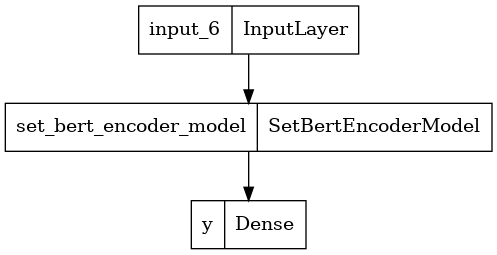

In [67]:
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

In [68]:
wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False

In [69]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[wandb_callback]
)

Epoch 1/5


2023-05-29 11:56:46.170506: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 522s 26s/step - loss: 0.4732 - val_loss: 0.6198
Epoch 2/5
20/20 [==============================] - 513s 26s/step - loss: 0.2900 - val_loss: 0.4811
Epoch 3/5
20/20 [==============================] - 513s 26s/step - loss: 0.3119 - val_loss: 0.6116
Epoch 4/5
20/20 [==============================] - 513s 26s/step - loss: 0.2508 - val_loss: 0.3391
Epoch 5/5
20/20 [==============================] - 513s 26s/step - loss: 0.2541 - val_loss: 0.4553


In [71]:
setbert_encoder.save("setbert_alex_mse")

INFO:tensorflow:Assets written to: setbert_alex_mse/assets


INFO:tensorflow:Assets written to: setbert_alex_mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
wandb.finish()

In [65]:
api = wandb.Api()

In [72]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v0").download()
setbert_encoder_pretrained = setbert.SetBertEncoderModel(
    load_model(path, setbert.SetBertPretrainModel).base
)
setbert_encoder_pretrained.base.dnabert_encoder.chunk_size = 256

wandb: Downloading large artifact setbert-pretrain-walker-abund-128d-250l:v0, 91.05MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


Number of outputs: 8


In [73]:
setbert_encoder = load_model("./setbert_alex_mse", setbert.SetBertEncoderModel)

Number of outputs: 8


In [74]:
trained_predictions = setbert_encoder(train_dataset[0][0], return_attention_scores=True)
untrained_predictions = setbert_encoder_pretrained(train_dataset[0][0], return_attention_scores=True)

# trained_predictions = setbert_encoder(val_dataset[0][0], return_attention_scores=True)
# untrained_predictions = setbert_encoder_pretrained(val_dataset[0][0], return_attention_scores=True)

In [75]:
len(trained_predictions[1])

1

In [76]:
len(trained_predictions[1][0])

8

In [77]:
# trained_predictions[1][0][0][0]

In [78]:
# untrained_predictions[1][0][0][0]

In [79]:
attention_scores = []
for i in range(len(trained_predictions[1][0])):
    attention_scores.append(trained_predictions[1][0][i].numpy() - untrained_predictions[1][0][i].numpy())
    # attention_scores.append(trained_predictions[1][0][i].numpy())
attention_scores = np.array(attention_scores)
attention_scores.shape

(8, 16, 8, 1001, 1001)

In [80]:
len(attention_scores)

8

In [81]:
attention_scores[0][0][0].shape

(1001, 1001)

In [82]:
attention_scores[0][0][0][0]

array([-9.02740285e-04, -1.92550942e-07,  9.30775423e-06, ...,
        3.73623334e-06,  1.20909535e-05, -4.74625267e-06], dtype=float32)

In [83]:
attention_scores[0][0][0][0].shape

(1001,)

In [84]:
attention_scores.shape

(8, 16, 8, 1001, 1001)

In [85]:
train_dataset[0][1]

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [86]:
attention_scores[1][0][0]

array([[ 2.8631911e-03, -7.7978475e-06, -2.1436717e-06, ...,
         6.4997002e-06,  1.7745770e-05,  7.8094890e-06],
       [-4.5812637e-02,  3.9226492e-05,  4.0229061e-05, ...,
         4.0416140e-05,  5.6519697e-05,  3.9644656e-05],
       [-4.8589498e-02,  4.2602769e-05,  4.3737062e-05, ...,
         4.5822584e-05,  5.8694102e-05,  4.5341789e-05],
       ...,
       [-8.3177146e-03, -3.2100361e-06, -6.9424277e-06, ...,
        -2.9882300e-05,  1.4784164e-05, -2.7429196e-05],
       [-2.9723220e-02,  1.9514933e-05,  1.6986625e-05, ...,
         4.9837399e-07,  4.0022423e-05,  2.3334287e-06],
       [-4.1783765e-02,  3.3993274e-05,  3.4088735e-05, ...,
         2.9030256e-05,  5.2750111e-05,  2.9012677e-05]], dtype=float32)

In [87]:
index = 0

<AxesSubplot:>

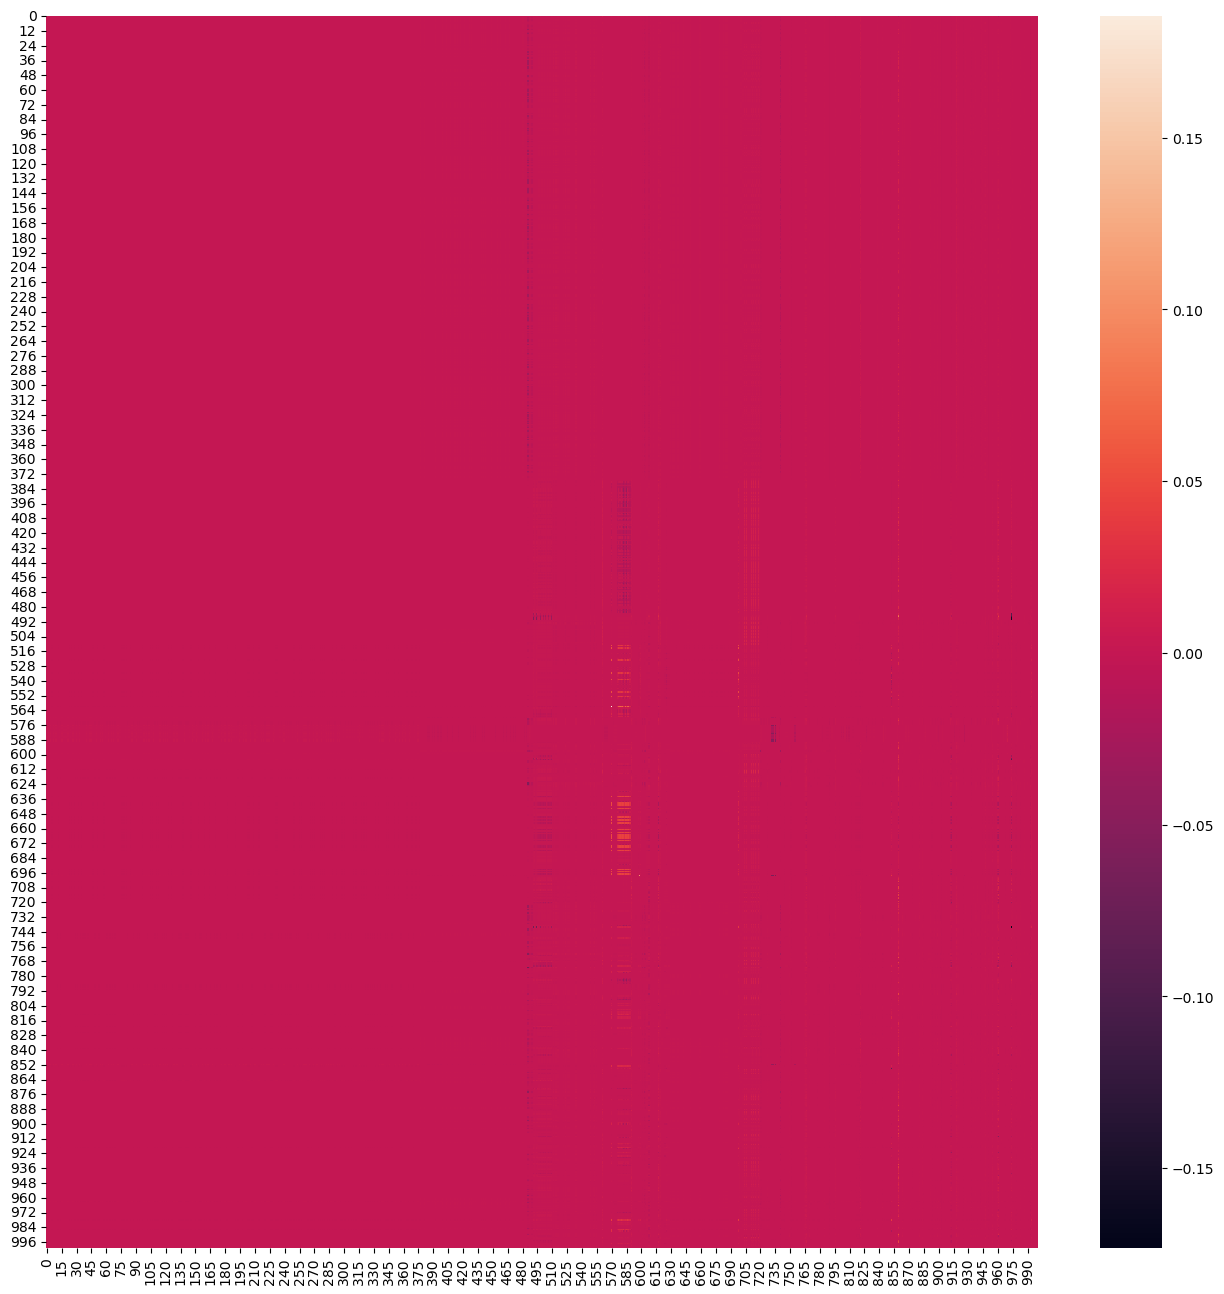

In [88]:
plt.figure(figsize=(16, 16))
sns.heatmap(attention_scores[-1][index][6])

In [89]:
a = []
for i in range(len(attention_scores)):
    a.append(np.sum(attention_scores[i][index], axis=(0, 1)))
a = np.array(a)[:,1:]
a.shape

(8, 1000)

In [90]:
tf.nn.top_k(a[-1], 5)

TopKV2(values=<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([167.1353  ,  56.09004 ,  34.60264 ,  25.12166 ,  18.449278],
      dtype=float32)>, indices=<tf.Tensor: shape=(5,), dtype=int32, numpy=array([602, 836, 993, 855, 500], dtype=int32)>)

Text(50.722222222222214, 0.5, 'Transformer Block')

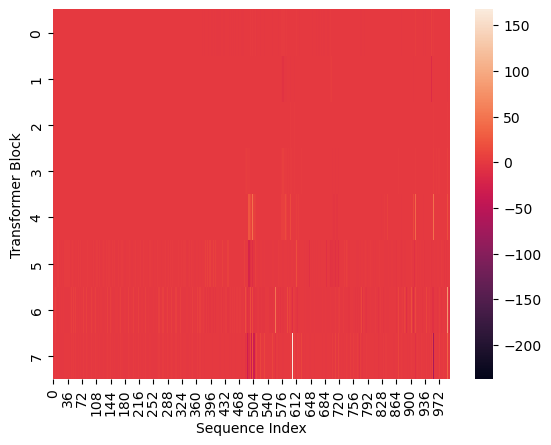

In [91]:
sns.heatmap(a)
plt.xlabel("Sequence Index")
plt.ylabel("Transformer Block")

<AxesSubplot:>

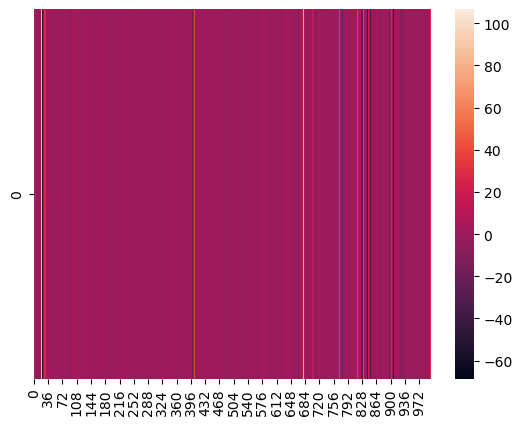

In [267]:
sns.heatmap(np.expand_dims(np.sum(attention_scores[-1][index], axis=(0, 1)), 0))

<AxesSubplot:>

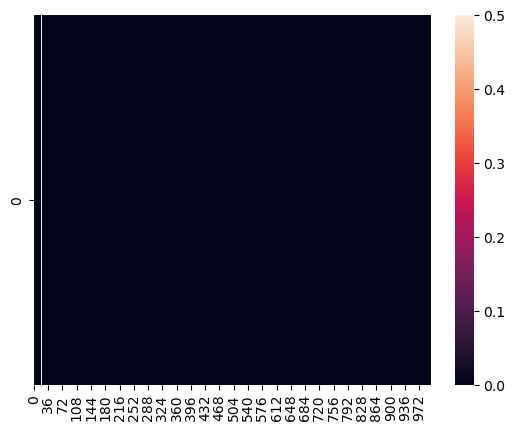

In [268]:
sns.heatmap(np.expand_dims(tf.nn.softmax(np.sum(attention_scores[-1][index][2] + attention_scores[-1][index][4], axis=0)), 0))

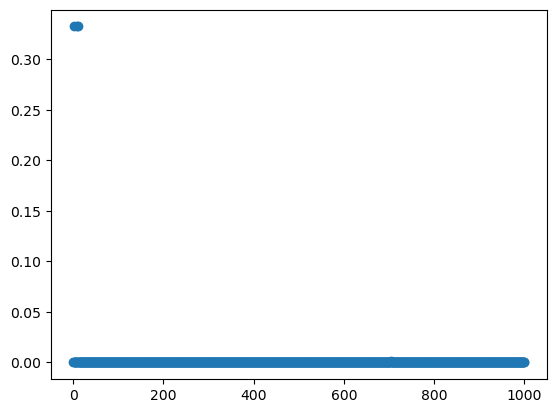

In [269]:
plt.scatter(np.arange(1001), tf.nn.softmax(np.sum(attention_scores[-1][2][3], axis=0)))